In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

from PIL import Image
from tools import analytics
from core.tops.config.instantiate import instantiate
import torchvision
import torch
import numpy as np
from matplotlib import pyplot as plt

from core.tops import torch_utils

from pytorch_grad_cam import AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.ablation_layer import AblationLayer
from collections import OrderedDict
import cv2
import numpy as np
from vizer.draw import draw_boxes

from scripts.save_comparison_images import convert_image_to_hwc_byte, create_comparison_image
from scripts.save_comparison_images import get_config, get_trained_model, get_dataloader, create_prediction_image


import requests

In [2]:
# import requests
# import torchvision
# from PIL import Image

# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# image_url = "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg"

# image = np.array(Image.open(requests.get(image_url, stream=True).raw))
# image_float_np = np.float32(image) / 255

# # define the torchvision image transforms
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
# ])

# input_tensor = transform(image)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_tensor = input_tensor.to(device)
# # Add a batch dimension:
# input_tensor = input_tensor.unsqueeze(0)

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model.eval().to(device)

# # Run the model and display the detections
# boxes, classes, labels, indices = predict(input_tensor, model, 0.9)
# image = draw_boxes(boxes, labels, classes, image)

# # Show the image:
# Image.fromarray(image)

Loading config from: core/configs/task4/retina_P4_retrain_overfit.py
--------------------------------------------------------------------------------


2022-04-28 02:23:16,832 [INFO ] Loaded checkpoint from outputs/configs/task4/retina_P4_retrain_overfit/checkpoints/4019.ckpt


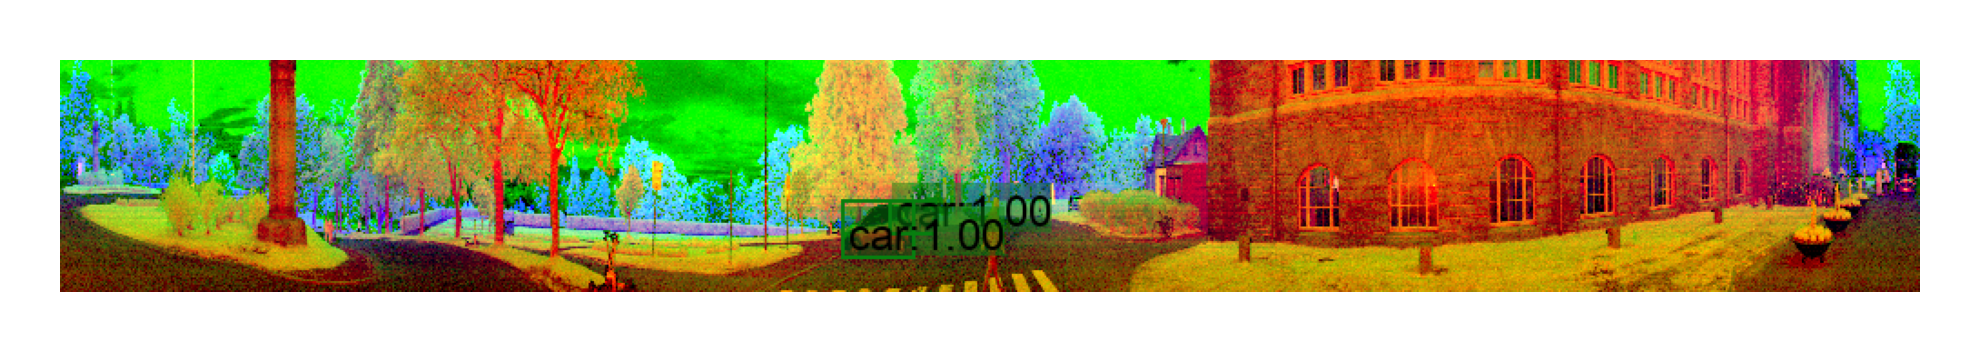

In [3]:
CFG_PATH = "core/configs/task4/retina_P4_retrain_overfit.py"

cfg = get_config(CFG_PATH)
model = get_trained_model(cfg)

train = True

if train:
    dataset_to_visualize = "train"
else:
    dataset_to_visualize = "val"

dataloader = iter(get_dataloader(cfg, dataset_to_visualize))

img_transform = instantiate(cfg.data_val.gpu_transform)

score_threshold = 0.99

batch = next(dataloader)

prediction_image, metainfo = create_prediction_image(
    batch, model, img_transform, cfg.label_map, score_threshold
)
labels = metainfo["labels"]
scores = metainfo["scores"]
classes = [cfg.label_map[label] for label in labels]
boxes = metainfo["boxes"]
plt.figure(figsize=(2, 16), dpi=1200)
plt.axis("off")
plt.imshow(prediction_image)

In [4]:
print(f"{boxes = }")
print(f"{classes = }")
print(f"{labels = }")

boxes = array([[456.6991 ,  77.63717, 482.78046,  96.36347],
       [430.66547,  77.59283, 470.9035 , 109.54484]], dtype=float32)
classes = ['car', 'car']
labels = [1, 1]


In [5]:
def fasterrcnn_reshape_transform(features):
    target_size = features[-1].size()[-2:]
    # target_size = x['pool'].size()[-2 : ]
    activations = []
    for feat in features:
        activations.append(torch.nn.functional.interpolate(torch.abs(feat), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

target_layers = [model.feature_extractor]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(),
               reshape_transform=fasterrcnn_reshape_transform)

input_tensor = torch.tensor(batch["image"]).cuda()
image_float_np = np.float32(batch["image"]) / 255
grayscale_cam = cam(input_tensor, targets=targets)
# # Take the first image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# # And lets draw the boxes again:
# image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
# Image.fromarray(image_with_bounding_boxes)

Activations
torch.Size([1, 256, 32, 256])
torch.Size([1, 256, 16, 128])
torch.Size([1, 256, 8, 64])
torch.Size([1, 256, 4, 32])
torch.Size([1, 256, 2, 16])
torch.Size([1, 256, 1, 8])
reshape_transform
model_outputs = {'boxes': tensor([[ 8.7516e-01, -5.8711e-04,  9.9897e-01,  9.8575e-01]], device='cuda:0',
       grad_fn=<IndexBackward0>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2200], device='cuda:0', grad_fn=<IndexBackward0>)}
output = tensor([0.], device='cuda:0')


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
targets